<a href="https://colab.research.google.com/github/mrunalkute/DS-Machine-Learning-Assignments/blob/Homework/Visualization_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

In [ ]:
! git clone https://github.com/ds3001f25/visualization_assignment.git

Cloning into 'visualization_assignment'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 8 (from 1)
Receiving objects: 100% (10/10), 1.88 MiB | 7.01 MiB/s, done.


In [ ]:
#import the required packages + the csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read the csv
from google.colab import files

uploaded = files.upload() #Choose the pretrial_data.csv file from the assignment and upload it!

Saving pretrial_data.csv to pretrial_data.csv


In [ ]:
#This is the bandwith function - Silverman's Rule

def silverman_bandwidth(x: np.ndarray) -> float:
    x = np.asarray(x).ravel()
    n = x.size #number of data points
    sd = np.std(x, ddof=1) #sample std. deviation
    iqr = np.subtract(*np.percentile(x, [75, 25])) #IQR
    sigma = min(sd, iqr / 1.34) if (sd > 0 or iqr > 0) else 0.0 #Use 1.34 as a value to estimate spread

   #If data has no spread (constant values), return a small fallback bandwidth
    if sigma == 0.0:
        span = max(1.0, np.abs(x).max())
        return 1e-3 * span

    return 0.9 * sigma * n ** (-1/5) #This is Silverman's rule

In [ ]:
#Define the kernels
#Standard gaussian kernel
def _kernel_gaussian(z):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) #from formulas we went over in lecture
#Boxcar kernel
def _kernel_uniform(z):
    out = np.zeros_like(z)
    out[np.abs(z) <= 1] = 0.5
    return out
#Epanechnikov kernel
def _kernel_epanechnikov(z):
    out = np.zeros_like(z)
    mask = (np.abs(z) <= 1)
    out[mask] = 0.75 * (1 - z[mask]**2)
    return out
#I put all of the kernels into a dictionary just to keep track of everything more easily (I ran into a lot of errors with this part specifically if I wasn't keeping track of functions)
_KERNELS = {
    "gaussian": _kernel_gaussian,
    "uniform": _kernel_uniform,
    "epanechnikov": _kernel_epanechnikov
}

In [ ]:
#KDE plot
def kde1d(data, bandwidth=None, kernel="gaussian", grid=None, grid_size=512, cut=3.0):
    x = np.asarray(data).ravel()
    n = len(x)

    #This is the bandwith function
    h = bandwidth if bandwidth else silverman_bandwidth(x)

    #Kernel function with the kernel dictionary
    kfun = _KERNELS[kernel]

    #Grid (I had to research this part online because I kept getting errors)
    if grid is None:
        xmin, xmax = x.min() - cut*h, x.max() + cut*h
        xs = np.linspace(xmin, xmax, grid_size)
    else:
        xs = np.asarray(grid)

    #Compute density here
    Z = (xs[:, None] - x[None, :]) / h
    K = kfun(Z) #apply kernel function
    fhat = K.sum(axis=1) / (n * h) #Density estimate

    return xs, fhat

In [ ]:
#KDE Plot
def plot_kde(data, bandwidth=None, kernel="gaussian", ax=None, label=None):
    xs, fhat = kde1d(data, bandwidth=bandwidth, kernel=kernel) #compute the kde estimate

#Create the plot axis here
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(xs, fhat, label=label or f"{kernel} kernel") #plot density curve
    ax.set_xlabel("x") #add labels + legend + make it pretty!
    ax.set_ylabel("Density")
    ax.legend()

    return xs, fhat, ax

In [ ]:
#I loaded the data here again because even though the "pre-trial csv" was loaded I was having problems at this point
from google.colab import files
import pandas as pd

uploaded = files.upload()

df = pd.read_csv("pretrial_data.csv")

#Check the columns
print(df.head())
print(df.columns)

Saving pretrial_data.csv to pretrial_data (2).csv
   Unnamed: 0 case_type   age sex race  is_poor  bond  bond_type  prior_F  \
0           0         F  31.0   M    W      NaN   NaN          7      0.0   
1           1         F  60.0   M    B      NaN   NaN          7     13.0   
2           2         M  27.0   M    W      NaN   NaN          7      0.0   
3           3         M  27.0   M    B      0.0   NaN          7      0.0   
4           4         F  28.0   F    W      0.0   NaN          7      0.0   

   prior_M  gini  released  sentence_type   sentence  bond_NA  held_wo_bail  \
0      0.0  0.44       NaN            NaN        NaN     True         False   
1     21.0  0.44       0.0            0.0  60.000000     True         False   
2      0.0  0.44       0.0            1.0  12.000000     True         False   
3      9.0  0.44       0.0            1.0   0.985626     True         False   
4      0.0  0.44       1.0            4.0   0.000000     True         False   

   sentence_

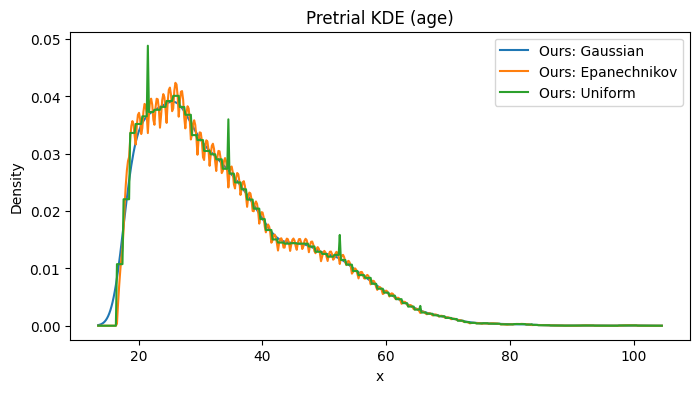

In [ ]:
#I ran the data on "age" because it was the easiest variable but it can be any numeric column (data) in the set!
col = "age"
series = df[col].dropna() #drop the missing values, I did this just in case!

fig, ax = plt.subplots(figsize=(8,4))

#Plot the KDE with the different kernels
plot_kde(series, kernel="gaussian", ax=ax, label="Ours: Gaussian")
plot_kde(series, kernel="epanechnikov", ax=ax, label="Ours: Epanechnikov")
plot_kde(series, kernel="uniform", ax=ax, label="Ours: Uniform")

#Title + print the plot
plt.title(f"Pretrial KDE ({col})")
plt.show()


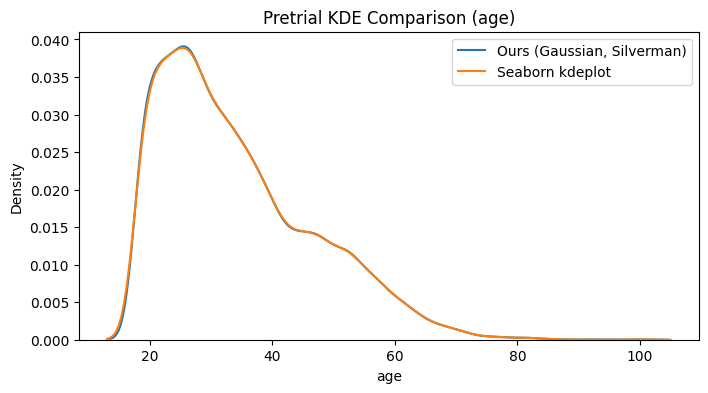

In [ ]:
#Comparing my plot with the seaborn KDE plot
#Import the seaborn package
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))

#This is my version from code
xs, fhat = kde1d(series, kernel="gaussian")
ax.plot(xs, fhat, label="Ours (Gaussian, Silverman)")

#This is the seaborn KDE plot
sns.kdeplot(x=series, ax=ax, label="Seaborn kdeplot", lw=1.5)

#Make it pretty + print!
ax.set_title(f"Pretrial KDE Comparison ({col})")
ax.legend()
plt.show()

**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?

In [2]:
# 2.1: Load the Data
#Import neccesary packages (I know I already did this for the first question so I should technically be fine, however, I just wanted to make sure that I was good)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

uploaded = files.upload() #Choose the "college_completion.csv" file and upload it!

df1= pd.read_csv("college_completion.csv") #I did not want to overwrite the previous data frame

Saving college_completion.csv to college_completion.csv


In [3]:
# 2.2: Data Dimensions
#print all of this
print("Shape:", df1.shape)   #(rows, columns)
print("Columns:", df1.columns.tolist())
print("Observations:", len(df1))

#Look at the first couple of rows to make sure everything is good
df1.head()

Shape: (3798, 63)
Columns: ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_after4_transfer', 'vsa_grad_elsewhere_after4_transfer', 'vsa_e

,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


Question 2.2:

There are 3,798 observations. The columns are 'index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_after4_transfer', 'vsa_grad_elsewhere_after4_transfer', 'vsa_enroll_after4_transfer', 'vsa_enroll_elsewhere_after4_transfer', 'vsa_grad_after6_transfer', 'vsa_grad_elsewhere_after6_transfer', 'vsa_enroll_after6_transfer', 'vsa_enroll_elsewhere_after6_transfer', 'similar', 'state_sector_ct', 'carnegie_ct', 'counted_pct', 'nicknames', 'cohort_size'

In [4]:
#Question 2.3: Crosstabulate
assert {"control","level"}.issubset(df1.columns), "Expected 'control' and 'level' in columns."
ct = pd.crosstab(df1["control"], df1["level"])
print("Crosstab: control x level")
ct

Crosstab: control x level


level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


There are more private not-for-profit 4 year programs than private for-profit. There are also more private for-profit 2 year programs than private not-for profit.

Text(0.5, 1.0, 'Histogram of Graduation Rate')

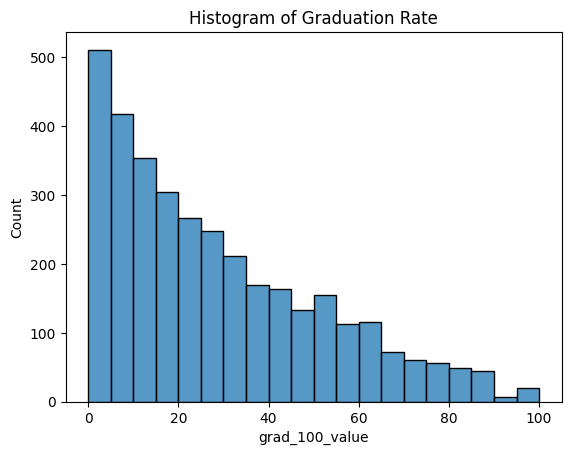

In [7]:
#Question 2.4: Create plots for grad_100_level
#Histogram
sns.histplot(data=df1, x="grad_100_value", bins=20)
plt.title("Histogram of Graduation Rate")

Text(0.5, 1.0, 'KDE of Graduation Rate')

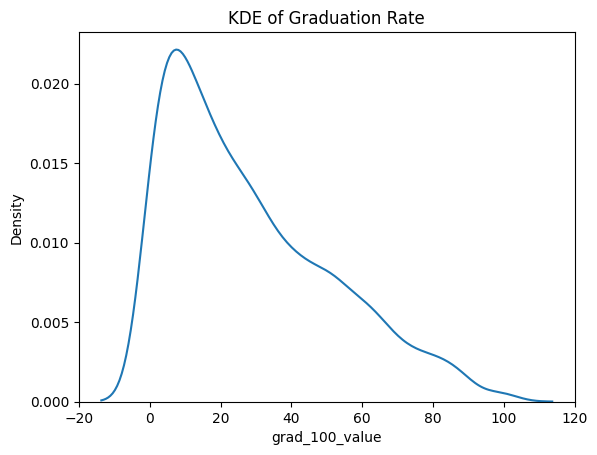

In [8]:
#KDE
sns.kdeplot(data=df1, x="grad_100_value")
plt.title("KDE of Graduation Rate")

Text(0.5, 1.0, 'Boxplot of Graduation Rate')

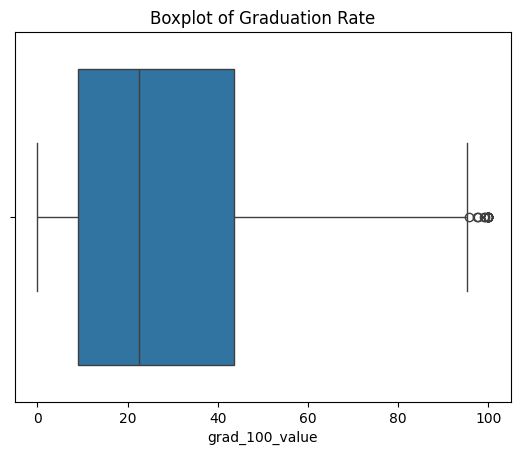

In [9]:
#Boxplot
sns.boxplot(data=df1, x="grad_100_value")
plt.title("Boxplot of Graduation Rate")

In [10]:
#Statistical Description
df1['grad_100_value'].describe()

,grad_100_value
count,3467.000000
mean,28.364465
std,23.312730
min,0.000000
25%,9.000000
50%,22.500000
75%,43.650000
max,100.000000


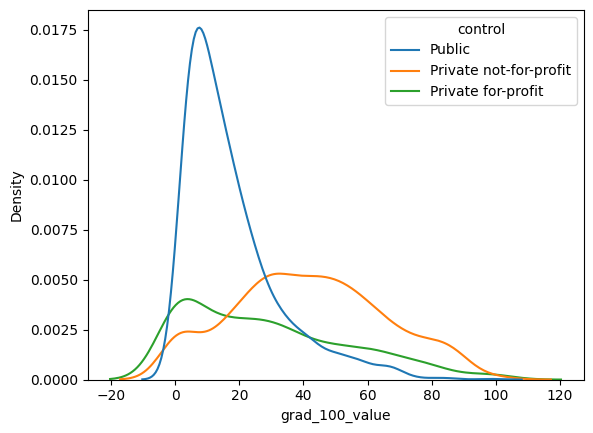

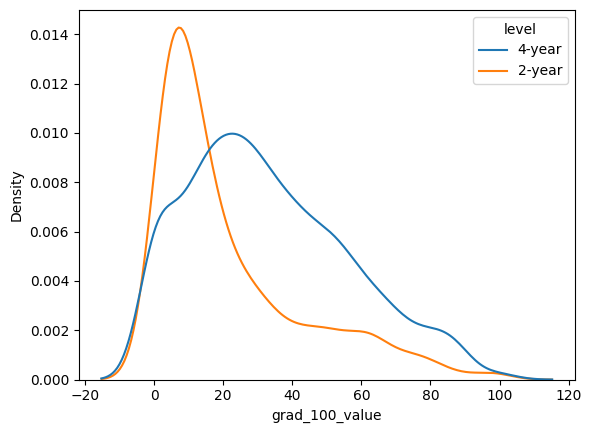

                                count       mean        std  min     25%  \
level  control                                                             
2-year Private for-profit       461.0  37.197614  25.497380  0.0  15.800   
       Private not-for-profit    68.0  41.913235  28.348302  0.0  16.225   
       Public                   926.0  12.400000  10.893600  0.0   5.100   
4-year Private for-profit       318.0  17.382704  20.788525  0.0   0.000   
       Private not-for-profit  1121.0  41.645674  23.243453  0.0  25.000   
       Public                   573.0  25.561082  16.403902  0.0  13.600   

                                50%     75%    max  
level  control                                      
2-year Private for-profit      33.9  57.800  100.0  
       Private not-for-profit  44.4  61.200  100.0  
       Public                   9.4  16.175   97.8  
4-year Private for-profit      12.5  26.325  100.0  
       Private not-for-profit  41.0  57.800  100.0  
       Public       

In [11]:
#Question 2.5: Group KDE
#KDE by control
sns.kdeplot(data=df1, x='grad_100_value', hue='control')
plt.show()

#KDE by level
sns.kdeplot(data=df1, x='grad_100_value', hue='level')
plt.show()

#Grouped stats
print(df1.groupby(['level','control'])['grad_100_value'].describe())

Question 2.5:

For the KDE plots for the "control" and the "level" I observed the following:

For control: Private not-for-profit schools show much higher graduation rates than both public and private for-profit schools, which are clustered at lower values.

For level: 4-year institutions have noticeably higher graduation rates compared to 2-year institutions, which are concentrated at the very low end.

Based on the grouped statistics, private not-for-profit institutions (both 2-year and 4-year) have the highest mean and median graduation rates, while public 2-year institutions consistently have the lowest. Private for-profit schools fall in between, with wide variability but generally lower averages than private not-for-profits.

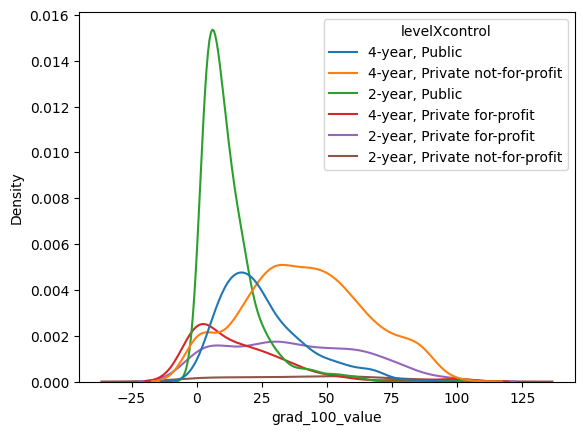

In [12]:
#Question 2.6: New Variable "levelXcontrol"
df1['levelXcontrol'] = df1['level'] + ", " + df1['control']
#Group KDE plot
sns.kdeplot(data=df1, x='grad_100_value', hue='levelXcontrol')
plt.show()

Question 2.5:
From this plot, 4-year private not-for-profit institutions stand out as having the best graduation rates, with their distribution shifted much farther to the right compared to other groups. In contrast, 2-year public institutions cluster heavily at the very low end, showing the weakest graduation outcomes.

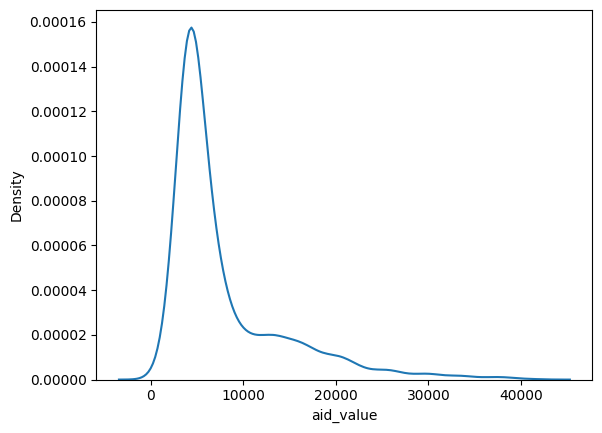

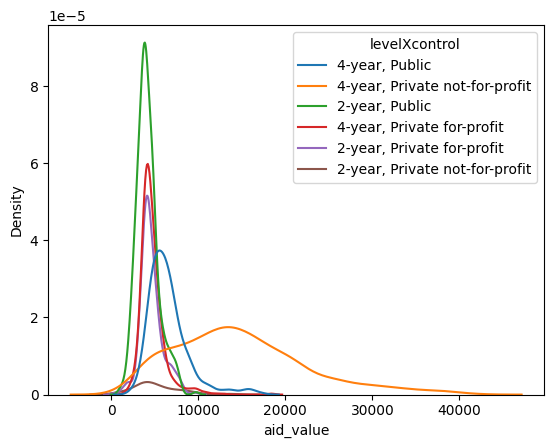

                                count          mean          std     min  \
level  control                                                             
2-year Private for-profit       464.0   4559.681034  1286.688269   294.0   
       Private not-for-profit    68.0   5128.058824  2590.449946   934.0   
       Public                   926.0   4126.199784  1260.271382   881.0   
4-year Private for-profit       527.0   4696.062619  1489.410020  1580.0   
       Private not-for-profit  1180.0  14702.401695  7649.775203   902.0   
       Public                   632.0   6514.071203  2353.716693  2232.0   

                                   25%      50%       75%      max  
level  control                                                      
2-year Private for-profit      3818.75   4286.5   5122.00   9727.0  
       Private not-for-profit  3650.00   4516.5   6311.50  13654.0  
       Public                  3311.25   3943.5   4762.00   9809.0  
4-year Private for-profit      3885.50   4364.

In [13]:
#Question 2.7: KDE for "aid_value"
#KDE overall
sns.kdeplot(df1['aid_value'])
plt.show()

#KDE grouped
sns.kdeplot(data=df1, x='aid_value', hue='levelXcontrol')
plt.show()

#Grouped stats
print(df1.groupby(['level','control'])['aid_value'].describe())

Question 2.7:

The distribution of aid values is highly right-skewed, with most public institutions clustering at lower aid amounts since they charge lower tuition and rely on state funding. In contrast, private not-for-profit schools show a wider spread and a long right tail, reflecting higher tuition costs and larger aid packages. Private for-profits fall in between, resulting in the overall peak at middle aid levels and a tapering of the graph as aid amounts increase.

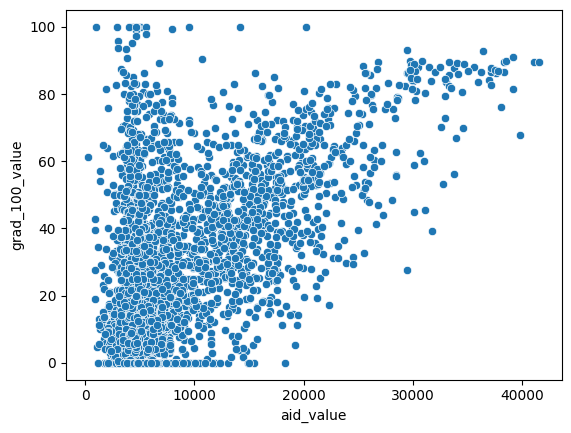

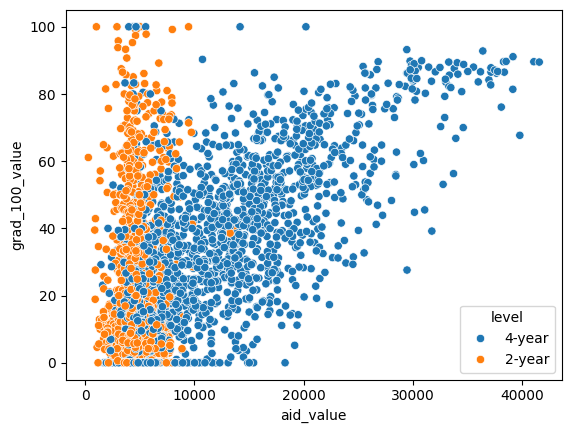

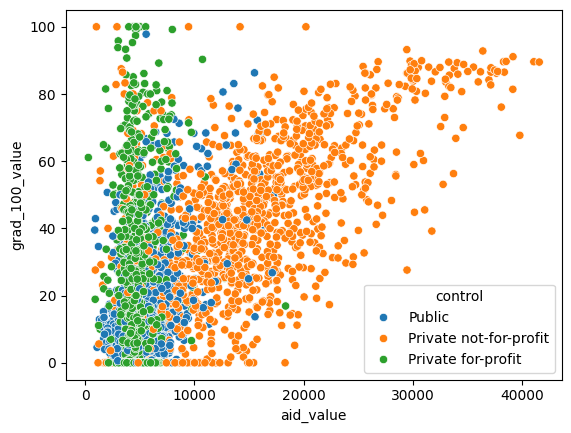

In [14]:
#Question 2.8: Scatterplots
#Overall scatter with "aid_value" and "grad_100_value"
sns.scatterplot(data=df1, x='aid_value', y='grad_100_value')
plt.show()

#By level
sns.scatterplot(data=df1, x='aid_value', y='grad_100_value', hue='level')
plt.show()

# By control
sns.scatterplot(data=df1, x='aid_value', y='grad_100_value', hue='control')
plt.show()

Question 2.8:

The scatterplot shows a weak positive relationship between aid_value and grad_100_value: as average aid increases, graduation rates tend to be higher, though the data are widely scattered. Most institutions cluster at lower aid amounts and lower graduation rates, but some with very high aid also reach the highest graduation outcomes.

The plots for the "level" and "control" show that 4-year institutions, especially private not-for-profit schools, have a clearer positive relationship between aid and graduation rates: higher aid values are associated with higher completion rates. In contrast, 2-year schools and for-profit institutions cluster at lower aid levels with weaker or inconsistent links to graduation success.